In [1]:
import numpy as np
# for plotting
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from scipy.interpolate import griddata
from pyDOE import lhs

import time

In [2]:
# Fix a seed for reproducibility

np.random.seed(1234)
tf.set_random_seed(1234)

In [3]:
""" Define the class for Physics Informed Neural Network specific for the 2D steady Darcy problem with piecewise constant diffusion coefficient """

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, alpha, forcing_fun):
        """  Defining global parameters in the class PhysicsInformedNN.
             Input: X_u = Subset of the training points on the boundary. They are used as training point in the data-based term of the loss function
                    u = Boundary values relatives to X_u. They are used as training values in the data-based term of the loss function 
                    X_f = Points in the unit squared. Union of collocation points and boundary points. They are used as training point in the PDE term of the loss function
                    layers = Numbers of layers in the NN
                    lb = Minimum point in the domain: (0,0) in the unit square
                    ub = Maximum point in the domain: (1,1) in the unit square
                    alpha = diffusion coefficient in the PDE
                    forcing_fun = forcing function in the PDE
        """
        
        # Extremes on the boundary. For the unit squared: (0,0) and (1,1)
        self.lb = lb
        self.ub = ub
        # (x,y) \in boundary of [0,1] * [0,1] (training points/BC points)
        self.x_u = X_u[:,0:1]       # x values 
        self.y_u = X_u[:,1:2]       # y values 
        # Collocation points:
        # Subdomain 1
        self.x1_f = X_f[0,:,0:1]       # x values 
        self.y1_f = X_f[0,:,1:2]       # y values 
        # Subdomain 2
        self.x2_f = X_f[1,:,0:1]       # x values 
        self.y2_f = X_f[1,:,1:2]       # y values 
        # Subdomain 3
        self.x3_f = X_f[2,:,0:1]       # x values 
        self.y3_f = X_f[2,:,1:2]       # y values 
        # Subdomain 4
        self.x4_f = X_f[3,:,0:1]       # x values 
        self.y4_f = X_f[3,:,1:2]       # y values
        # BC
        self.u = u
        # PDE coefficients: diffusion coefficient and forcing function   
        self.forcing_fun = forcing_fun 
        self.alpha1 = alpha[0]
        self.alpha2 = alpha[1]
        self.alpha3 = alpha[2]
        self.alpha4 = alpha[3]
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
    
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])   # Tensor that can be used to feed a value but cannot be evaluated directly.
        self.y_u_tf = tf.placeholder(tf.float32, shape=[None, self.y_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        # Subdomain 1
        self.x1_f_tf = tf.placeholder(tf.float32, shape=[None, self.x1_f.shape[1]])
        self.y1_f_tf = tf.placeholder(tf.float32, shape=[None, self.y1_f.shape[1]]) 
        # Subdomain 2
        self.x2_f_tf = tf.placeholder(tf.float32, shape=[None, self.x2_f.shape[1]])
        self.y2_f_tf = tf.placeholder(tf.float32, shape=[None, self.y2_f.shape[1]]) 
        # Subdomain 3
        self.x3_f_tf = tf.placeholder(tf.float32, shape=[None, self.x3_f.shape[1]])
        self.y3_f_tf = tf.placeholder(tf.float32, shape=[None, self.y3_f.shape[1]]) 
        # Subdomain 4
        self.x4_f_tf = tf.placeholder(tf.float32, shape=[None, self.x4_f.shape[1]])
        self.y4_f_tf = tf.placeholder(tf.float32, shape=[None, self.y4_f.shape[1]])       

        # define the NN for sol u term
        self.u_pred = self.net_u(self.x_u_tf, self.y_u_tf) 
        # define the NN for PDE term:
        # Subdomain 1 
        self.f1_pred = self.net_f(self.alpha1, self.x1_f_tf, self.y1_f_tf) 
        # Subdomain 2 
        self.f2_pred = self.net_f(self.alpha2, self.x2_f_tf, self.y2_f_tf)     
        # Subdomain 3 
        self.f3_pred = self.net_f(self.alpha3, self.x3_f_tf, self.y3_f_tf)
        # Subdomain 4 
        self.f4_pred = self.net_f(self.alpha4, self.x4_f_tf, self.y4_f_tf)
 
        
        # Loss function: data-driven term (loss_u) + PDE term (loss_f)
        self.loss_u = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))
        self.loss_f = tf.reduce_mean(tf.square(self.f1_pred)) +\
                      tf.reduce_mean(tf.square(self.f2_pred)) +\
                      tf.reduce_mean(tf.square(self.f3_pred)) +\
                      tf.reduce_mean(tf.square(self.f4_pred))

        self.loss = tf.reduce_mean(tf.square(self.u_tf- self.u_pred)) +\
                    tf.reduce_mean(tf.square(self.f1_pred)) +\
                    tf.reduce_mean(tf.square(self.f2_pred)) +\
                    tf.reduce_mean(tf.square(self.f3_pred)) +\
                    tf.reduce_mean(tf.square(self.f4_pred))
                                                         
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1. * np.finfo(float).eps})
        
    
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        """ Define the structure of the NN.
            Input: X = NN input. The coordinates on the boundary for the u_NN
                                 Collocation points for the PDE_NN
                   weights = weigths (NN unknonwns)
                   biases = biases (NN unknonwns)
            Output: Y = NN output. Solution u of the problem
        """ 
        num_layers = len(weights) + 1
        
        #H = X      # No scaling
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0     # Scaling --> in [-1,1]^2
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y


    def net_u(self, x, y):
        u = self.neural_net(tf.concat([x,y],1), self.weights, self.biases) # tf.concat([x,y],1) = tensor with shape = (x.shape[0], x.shap[1]+y.shape[1]), array([x_1riga, y_1riga],..,[x_nriga, y_nriga])
        return u
    
    def net_f(self, alpha, x, y):
        """ Define the PDE: 2D-Darcy equation -grad(alpha(x,y) grad(u(x,y))) = 1
        """
        u = self.net_u(x,y)
        forcing_fun = self.forcing_fun
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]

        f = forcing_fun + alpha * u_xx + alpha * u_yy
        return f

    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.x_u_tf: self.x_u, self.y_u_tf: self.y_u, self.u_tf: self.u,
                   self.x1_f_tf: self.x1_f, self.y1_f_tf: self.y1_f,
                   self.x2_f_tf: self.x2_f, self.y2_f_tf: self.y2_f,
                   self.x3_f_tf: self.x3_f, self.y3_f_tf: self.y3_f,
                   self.x4_f_tf: self.x4_f, self.y4_f_tf: self.y4_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)

                
    def loss_functions(self):
        loss_u = self.sess.run(self.loss_u, {self.x_u_tf: self.x_u, self.y_u_tf: self.y_u, self.u_tf: self.u})  
        loss_f = self.sess.run(self.loss_f, {self.x1_f_tf: self.x1_f, self.y1_f_tf: self.y1_f,
                                             self.x2_f_tf: self.x2_f, self.y2_f_tf: self.y2_f,
                                             self.x3_f_tf: self.x3_f, self.y3_f_tf: self.y3_f,
                                             self.x4_f_tf: self.x4_f, self.y4_f_tf: self.y4_f})  
        loss = self.sess.run(self.loss, {self.x_u_tf: self.x_u, self.y_u_tf: self.y_u, self.u_tf: self.u,
                                         self.x1_f_tf: self.x1_f, self.y1_f_tf: self.y1_f,
                                         self.x2_f_tf: self.x2_f, self.y2_f_tf: self.y2_f,
                                         self.x3_f_tf: self.x3_f, self.y3_f_tf: self.y3_f,
                                         self.x4_f_tf: self.x4_f, self.y4_f_tf: self.y4_f})  
    
        return loss_u, loss_f, loss

    def predict(self, X_star, n_points):

        n = n_points
        n_half = int(n/2)

        n_star = X_star.shape[0]
        n_star_half = int(n_star/2)

        X_star1 = X_star[0:n_half, :]
        X_star4 = X_star[n_half:n, :]
        X_star2 = X_star[n_star_half : n_star_half + n_half, :]
        X_star3 = X_star[n_star_half + n_half : n_star_half + n ,:]
        for i in range(1,n_half):
            n1_1, n1_2 = n_half*2*i, n_half*2*i + n_half
            n4_1, n4_2 = n_half*2*i + n_half, n*i + n 
            n2_1, n2_2 = n_star_half + n_half*2*i, n_star_half + n_half*2*i + n_half
            n3_1, n3_2 = n_star_half + n_half*2*i + n_half, n_star_half + n*i + n 
            X_star1_new = X_star[n1_1:n1_2, :]
            X_star2_new = X_star[n2_1:n2_2, :]
            X_star3_new = X_star[n3_1:n3_2, :]
            X_star4_new = X_star[n4_1:n4_2, :]
            X_star1 = np.vstack((X_star1, X_star1_new))
            X_star2 = np.vstack((X_star2, X_star2_new))
            X_star3 = np.vstack((X_star3, X_star3_new))
            X_star4 = np.vstack((X_star4, X_star4_new))

                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.y_u_tf: X_star[:,1:2]})  
        f_star1 = self.sess.run(self.f1_pred, {self.x1_f_tf: X_star1[:,0:1], self.y1_f_tf: X_star1[:,1:2]})
        f_star2 = self.sess.run(self.f2_pred, {self.x2_f_tf: X_star2[:,0:1], self.y2_f_tf: X_star2[:,1:2]})
        f_star3 = self.sess.run(self.f3_pred, {self.x3_f_tf: X_star3[:,0:1], self.y3_f_tf: X_star3[:,1:2]})
        f_star4 = self.sess.run(self.f4_pred, {self.x4_f_tf: X_star4[:,0:1], self.y4_f_tf: X_star4[:,1:2]})
        
        f_star = np.vstack((f_star1, f_star2, f_star3, f_star4))    
        return u_star, f_star        
                                    

Loss: 4.02831
Loss: 4.27788
Loss: 3.46096
Loss: 2.78595
Loss: 2.03613
Loss: 1.41166
Loss: 0.867824
Loss: 0.341994
Loss: 0.353107
Loss: 0.184996
Loss: 0.109356
Loss: 0.0591324
Loss: 0.0396259
Loss: 0.0354546
Loss: 0.0318835
Loss: 0.0240224
Loss: 0.0104058
Loss: 0.00640432
Loss: 0.00546161
Loss: 0.00525354
Loss: 0.00491328
Loss: 0.00437514
Loss: 0.00339344
Loss: 0.00297836
Loss: 0.00277672
Loss: 0.0026419
Loss: 0.00252504
Loss: 0.00243626
Loss: 0.00234844
Loss: 0.00231665
Loss: 0.00226992
Loss: 0.00218698
Loss: 0.00200614
Loss: 0.00183628
Loss: 0.0016917
Loss: 0.00156513
Loss: 0.00144694
Loss: 0.00139792
Loss: 0.0013427
Loss: 0.00135422
Loss: 0.00131619
Loss: 0.00126977
Loss: 0.00114471
Loss: 0.00105496
Loss: 0.00130656
Loss: 0.000961675
Loss: 0.000969595
Loss: 0.000920514
Loss: 0.000866929
Loss: 0.000816397
Loss: 0.000749316
Loss: 0.000681919
Loss: 0.0010367
Loss: 0.000643277
Loss: 0.00060343
Loss: 0.000575936
Loss: 0.000556343
Loss: 0.00055009
Loss: 0.000545655
Loss: 0.000543044
Loss: 

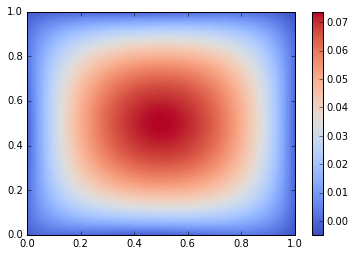

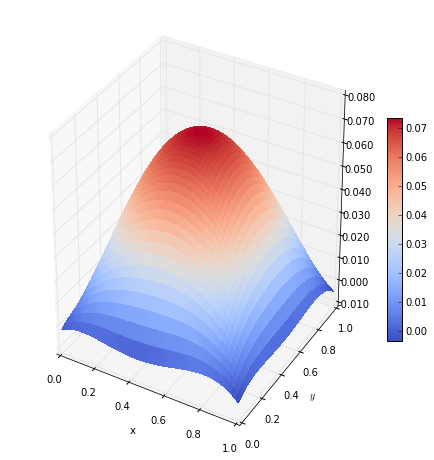

u_pred minimum = -0.004756569862365723


In [4]:
if __name__ == "__main__":        
    
    # Tunning parameters 
    n_points = 130 #            # We define more datapoints. Always chose an EVEN NUMBER
    n_halfpoints = int(n_points/2)
    N_training = 100            # Number of training points for each boundary. We know the exact solution only on the boundaries: from the BCs --> N_training total = 4*N_training
    N_collocation = 2500        # Number of collocation points, for each subdomain, where we evaluated the PDE. N_collocation total = 4* N_collocation
    layers =  [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]  #  [2, 20, 20, 20, 20, 1]  # [2, 20, 1]  #  [2, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1]  #    #Input: (x,y) Output: sol u 
    
    # Define the boundary of the domain 
    tol =  1.e-4 # 1.e-5 # 1.e-3 #
    x_min = 0
    x_max = 1
    y_min = 0
    y_max = 1

    # Whole domain: x and y coordinates
    x = np.linspace(x_min,x_max,n_points) #prepare to NN
    y = np.linspace(y_min,y_max,n_points) #prepare to NN
    # Coordinates of the points in the whole domain: X.shape = Y.shape = torch.Size([n_points])
    X,Y = np.meshgrid(x,y)           # X.shape = Y.shape = torch.Size([n_points])
    # X_star[:,0] = x values || X_star[:,1] = y values. We traverse the points on the unit square row by row, starting from y = 0
    X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))  #np.array, shape=(n_points^2,2)

    # Coordinates for the boundary. BC--> u=0 on \partial \Omega
    # BC y=0 and x \in [0,1]
    xy_y0 = np.hstack((X[0:1,:].T, Y[0:1,:].T))
    u_y0 = np.zeros(n_points).reshape(n_points,1)   
    # BC x=0 and y \in [0,1]
    xy_x0 = np.hstack((X[:,0:1], Y[:,0:1]))
    u_x0 = np.zeros(n_points).reshape(n_points,1)
    # BC y=1 and x \in [0,1]
    xy_y1 =  np.hstack((X[-1:,:].T, Y[-1:,:].T))
    u_y1 = np.zeros(n_points).reshape(n_points, 1)
    # BC x=1 and y \in [0,1]
    xy_x1 = np.hstack((X[:,-1:], Y[:,-1:]))
    u_x1 = np.zeros(n_points).reshape(n_points, 1)

    # Half boundary of subdomain 1
    xy_y0_1 = xy_y0[0:n_halfpoints, :]
    xy_x0_1 = xy_x0[0:n_halfpoints, :]
    # Half boundary of subdomain 2
    xy_x0_2 = xy_x0[n_halfpoints:n_points, :]
    xy_y1_2 = xy_y1[0:n_halfpoints, :]
    # Half boundary of subdomain 3
    xy_y1_3 = xy_y1[n_halfpoints:n_points, :]
    xy_x1_3 = xy_x1[n_halfpoints:n_points, :]
    # Half boundary of subdomain 4
    xy_x1_4 = xy_x1[0:n_halfpoints, :]
    xy_y0_4 = xy_y0[n_halfpoints:n_points, :]

    # Domain bounds (needed for define collocation points)
    lb = X_star.min(0)
    ub = X_star.max(0)
    # Subdomain 1 bounds
    lb1 = np.array((0.,0.)) 
    ub1 = np.array((0.5 + tol, 0.5 + tol)) 
    # Subdomain 2 bounds
    lb2 = np.array((0., 0.5 - tol)) 
    ub2 = np.array((0.5 + tol, 1.))
    # Subdomain 3 bounds
    lb3 = np.array((0.5 - tol ,0.5 - tol)) 
    ub3 = np.array((1., 1.))
    # Subdomain 4 bounds
    lb4 = np.array((0.5 - tol, 0.)) 
    ub4 = np.array((1., 0.5 + tol))    

    # Define train points on the boundary and boundary conditions
    X_u_train = np.vstack([xy_y0, xy_x0, xy_y1, xy_x1])     # Boundary points
    u_train = np.vstack([u_y0, u_x0, u_y1, u_x1])           # Boundary conditios
    # Define train points on the boundary
    X_u_train1 = np.vstack([xy_y0_1, xy_x0_1])              # Subomain 1: half boundary points
    X_u_train2 = np.vstack([xy_x0_2, xy_y1_2])              # Subomain 1: half boundary points
    X_u_train3 = np.vstack([xy_y1_3, xy_x1_3])              # Subomain 1: half boundary points
    X_u_train4 = np.vstack([xy_x1_4, xy_y0_4])              # Subomain 1: half boundary points

    # Define training points for the PDE_loss in each subdomain
    X_f_train1 = lb1 + (ub1-lb1)*lhs(2, N_collocation)          # Subdomain 1: define N_collocation points randomly
    X_f_train2 = lb2 + (ub2-lb2)*lhs(2, N_collocation)          # Subdomain 2: define N_collocation points randomly
    X_f_train3 = lb3 + (ub3-lb3)*lhs(2, N_collocation)          # Subdomain 3: define N_collocation points randomly
    X_f_train4 = lb4 + (ub4-lb4)*lhs(2, N_collocation)          # Subdomain 4: define N_collocation points randomly
    # Define training points for the PDE_loss in each subdomain and on their boundaries
    X_f_train1 = np.vstack((X_f_train1, X_u_train1))
    X_f_train2 = np.vstack((X_f_train2, X_u_train2))
    X_f_train3 = np.vstack((X_f_train3, X_u_train3))
    X_f_train4 = np.vstack((X_f_train4, X_u_train4))

    X_f_train = np.stack((X_f_train1, X_f_train2, X_f_train3, X_f_train4)) # X_f_train.shape = (4, N_collocation, 2)         
    # Define a subset as training test for the BC (for the BC_loss)
    idx_y0 = np.random.choice(xy_y0.shape[0], N_training, replace=False)
    idx_x0 = np.random.choice(xy_x0.shape[0], N_training, replace=False)
    idx_y1 = np.random.choice(xy_y1.shape[0], N_training, replace=False)
    idx_x1 = np.random.choice(xy_x1.shape[0], N_training, replace=False)
    X_u_train = np.vstack([xy_y0[idx_y0,:], xy_x0[idx_x0,:], xy_y1[idx_y1,:], xy_x1[idx_x1,:]])
    u_train = np.vstack([u_y0[idx_y0,:], u_x0[idx_x0,:], u_y1[idx_y1,:], u_x1[idx_x1,:]]) 

    # PDE coefficients
    forcing_fun = 1.
    alpha = np.array((1., 1., 1., 1.))

    # Define the NN
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, alpha, forcing_fun)
    
    # Train the NN
    start_time = time.time()                
    model.train()
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    # Compute MSE_u, MSE_f and MSE
    loss_u, loss_f, loss = model.loss_functions()
    print('MSE_u:{} and MSE_f:{} and loss:{}'.format(loss_u, loss_f, loss))
    print('MSE_u + MSE_f = {} '.format(loss_u + loss_f))
    print('MSE = MSE_u + MSE_f --> {} = {} + {}'.format(loss, loss_u, loss_f))

    # Compute u predicted for plot in a grid 500 \times 500
    # Whole domain: x and y coordinates
    n_points_plot = 500
    x_plot = np.linspace(x_min,x_max,n_points_plot) #prepare to NN
    y_plot = np.linspace(y_min,y_max,n_points_plot) #prepare to NN
    X_plot,Y_plot = np.meshgrid(x_plot,y_plot)          
    X_star_plot = np.hstack((X_plot.flatten()[:,None], Y_plot.flatten()[:,None]))  #np.array, shape=(n_points^2,2)
    u_pred, f_pred = model.predict(X_star_plot, n_points_plot)
    U_pred = griddata(X_star_plot, u_pred.flatten(), (X_plot, Y_plot), method='cubic')
    F_pred = griddata(X_star_plot, f_pred.flatten(), (X_plot, Y_plot), method='cubic')


    # Plotting the surface
    print('plot solution for alpha = {}'.format(alpha)) 
    # 2D plot
    fig, ax = plt.subplots()
    p = ax.pcolor(X_plot, Y_plot, U_pred, cmap= cm.coolwarm, vmin=U_pred.min(), vmax=U_pred.max())
    cb = fig.colorbar(p, ax=ax)

    # 3D plot
    fig = plt.figure(figsize=(8,8))
    plt.rcParams["text.usetex"] = False
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X_plot, Y_plot, U_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.03f'))
    
    ax.set_xlabel('x')
    ax.set_ylabel(r'$y$')
   
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=15, pad=0.01) 

    plt.show()

    print('u_pred minimum = {}'.format(U_pred.min()))
